## Exact Diagonalization Project

This is my project for the exact diagonalization module. The goal is to simulate the time evolution of a $N=20$ spin chain. As a Hamiltonian, I use the critical Ising Hamiltonian.
The relevant variable that I keep track of is the entropy of entanglement $S_n$. for systems with $n=2,...,10$ spins. 

The expected behaviour is an increase of the entropy with time and then a saturation at $S_n=n$. 
The used definition for the entropy is $S = - \sum_i p(i) \log_2(p(i))$ with $p(i)$ being the eigenvalues of the reduced density matrix that describes the system.

In [1]:
using PyPlot
using Arpack
using LinearAlgebra

### Setup

These functions are used for storing the datasets. They are not very efficient in terms of storage space since everything is stored as a string. Nevertheless, I did not invest too much time in these functions.

In [2]:
function write_data(input::Array, file::String)
    f = open(file, "w")
    for i in 1:length(input[:,1])
        println(f, string.(input[i,:]))
    end
    close(f) 
end;
#8
function read_data(file::String, T::Type) #not used anymore
    f = open(file, "r")
    output = T[]
    for i in eachline(f)
        output = push!(output, parse(T, i[3:end-2]))
    end
    close(f)
    output
end
#18
function read_data_matrix(file::String, T::Type, dim::Int) 
    f = open(file, "r")
    lines = readlines(f)
    rdata = zeros(T, length(lines), dim)
    for i in 1:length(lines)
        output = split(lines[i], ", ")
        output[1] = output[1][2:end]
        output[end] = output[end][1:end-1]
        for j in 1:length(output)
            rdata[i, j] = (parse(T, output[j][2:end-1]))
        end
    end
    close(f)
    rdata
end;

The function $multiplyHPsi$ is taken from the lecture, it uses the concept of sparse multiplication and the property of the Hamiltionian that it is local. It takes the current state vector as an input and outputs the Hamiltonion times the state vector.

In [3]:
# function for sparse multiplication

function multiplyHPsi(Psi, H2) 
    L = length(Psi)  # Dimension of the vector space
    N = convert(Int64,log2(L))  # Number of spins
    HPsi = zeros(L)
    for n=1:N                              # This multiplies by the Hamiltonian H
        Psi = reshape(Psi,(4,2^(N-2)))
        HPsi = reshape(HPsi,(4,2^(N-2)))
        HPsi += H2*Psi   
        Psi = reshape(Psi,(2,2^(N-1)))
        HPsi = reshape(HPsi,(2,2^(N-1)))
        Psi = permutedims(Psi,(2,1))
        HPsi = permutedims(HPsi,(2,1))
    end
    Psi = reshape(Psi,L)
    HPsi = reshape(HPsi, L)
    return HPsi
end;

Due to the long waiting times when I did the simulation, I made a progress bar, that shows the calculation time and the percentage of the progress.

In [4]:
function progress(a::Int, t::Float64, p::Int)
    x=" "^floor(Int, 100/p)
    x = replace(x, " " => "=", count=Int(a/p))
    ttg = round(((100/a)-1)*t; digits=2)
    println("[", x, "] ", a, "% progress; Calculation time: ", t, "s")
end;

$buildIsing$ creates the critical Ising Hamiltonian when called without an input. 

In [5]:
# Ising model (Hamiltonion for two spins)
function buildIsing(theta=pi/4) # Ising model with transverse magnetic field h (critical theta=pi/4 by default)
    X = [0. 1; 1 0]
    Z = [1. 0; 0 -1]
    E = diagm(0=>ones(2))
    XX = kron(X,X)
    HXX = XX
    HZ = kron(Z,E) + kron(E,Z) #contribution of two sites                also works:    HZ = kron(Z,E)
    H2 = -(cos(theta)*XX + sin(theta)/2*HZ) #divide by two since can be on both sites   son(theta)*HZ
    return H2
end

H2=buildIsing()

4×4 Array{Float64,2}:
 -0.707107  -0.0       -0.0       -0.707107
 -0.0       -0.0       -0.707107  -0.0     
 -0.0       -0.707107  -0.0       -0.0     
 -0.707107  -0.0       -0.0        0.707107

These two functions normalize/return the norm of a vector. I wrote them before noticing that the LinearAlgebra package probably has functions like these as well, but I continued using them during the project.

In [6]:
function mynormalize(a::Array)
    return a/mynorm(a)
end

function mynorm(a::Array)
    b=a'*a
    return sqrt(abs(b[1]))
end;

### Simulation

These are the important functions for the simulation. $calc\_subentropy$ calculates the entropy of entanglement for the systems with $n=2,...,10$ spins. The output is a 1x9 vector that contains the entropy of entanglement for each system.

The calculation is done by computing the reduced density matrix with the definition used in the lecture: The state vector is reshaped to $2^n$ lines and then multiplied by its "daggered" self. The $2^n$ eigenvalues of this reduced density matrix are calculated with $eigvals$ and put into the formula for the entropy mentioned above.

In [7]:
function calc_subentropy(psi::Array)
    entropies = zeros(Float64, 1, 9)
    for n in 2:10
        psi = reshape(psi, 2^N)
        psi = reshape(psi, (2^n, 2^(N-n)))
        #for i in 1:2^(N-n) #partial trace over system B
        #    dm += psi[:,i]*psi[:,i]' 
        #end
        dm = psi*psi'
        D = eigvals(dm)
        if abs(sum(D)-1) > 1e-4
            println("Careful for n=", n,": sum(D)=", sum(D))
        end
        for i in 1:length(D)
            if real(D[i]) > eps(Float64)
                entropies[n-1] -= D[i]*log2(D[i]) 
            end
        end
    end
    entropies
end;

Just down here, $N$ is set to twenty.

In [8]:
N=20;

For the $\textbf{first}$ time, the storage arrays are initialized here:

$timearray$ contains the the time at which the corresponing entropies were calculated.  These entropies are stored in $\textbf{store}$.

In [9]:
timearray = zeros(Float64, 0)
store = zeros(Float64, 0, 9)
currentTime = 0.

0.0

To initialize the simulation, a state vector is created by taking $N$ random spin vectors and multiplied with the Kronecker product.  

In [11]:
up = randn(ComplexF64, N)
down = randn(ComplexF64, N)
Psi = mynormalize([up[1], down[1]])
for i in 2:N
    Psi = kron(Psi, mynormalize([up[i], down[i]]))
end
display(mynorm(Psi))
display(length(Psi))

1.0000000000000009

1048576

For $\textbf{all further}$ iterations, the stored data is loaded with this cell.

In [21]:
Psi = read_data_matrix("psi.txt", ComplexF64, 1);
store = read_data_matrix("entropy.txt", Float64, 9);
timearray = read_data_matrix("time.txt", Float64, 1);
currentTime = timearray[end]

4560.0

This is just to check that everthing loaded in correctly.

In [22]:
display(length(timearray))
display(length(Psi))
display(length(store[:,1]))
display(length(store[1,:]))

45601

1048576

45601

9

As one can see, the two functions $calc\_subentropy$ and $multiplyHPsi$ are very time consuming. They both are called in the time evolution once for each timestep. The timestep is going to be set at around $0.1$ms, to simulate one second of time evolution, this simulation takes about 7 hours.

In [15]:
@time calc_subentropy(Psi)
@time multiplyHPsi(Psi, H2);

  0.892027 seconds (7.78 k allocations: 65.782 MiB, 1.75% gc time)
  1.519854 seconds (451 allocations: 1.258 GiB, 24.56% gc time)


This is the main function of the simulation. It takes the current state vector, the time for which the simulation should be done (in ms), the timestep size (in ms), the current time of the state vector since the beginning (in ms) and a parameter for the progress bar.
The output is a 9 column vector with the entropies for the systems after each timestep, the array that contains the corresponding times and the updated state vector.

For the time evolution, the formula
\begin{align*}
\left|\Psi(t)\right> &= e^{-iH(t-t_0)} \left|\Psi(t_0)\right> \\
\Rightarrow \left|\Psi(t+\Delta t)\right> &\approx \left|\Psi(t)\right> - i \Delta t \cdot H \left|\Psi(t)\right>
\end{align*}

for $\Delta t$ small enough.

In [16]:
function timeEvolution(psi::Array, Time::Float64, deltat::Float64, cTime::Float64, p::Int)
    t1=time()
    counter=Int(p);
    timesteps = ceil(Int, Time/deltat)
    timearr = range(cTime, step = deltat, length=timesteps+1)
    sto = zeros(timesteps+1, 9)
    sto[1,:] = calc_subentropy(psi)
    for i in 1:timesteps
        #Update Psi and calculate entropy of the systems
        psi = psi - im*1e-3*deltat*multiplyHPsi(psi, H2) 
        sto[i+1,:] = calc_subentropy(psi)
        #Progress bar
        if i/timesteps*100 >= counter
            t3 = time()
            progress(counter, round(t3-t1; digits=2),p)
            counter += p
        end
        #Check if renormalization is needed
        if abs(mynorm(psi)-1) > 1e-5
            #println("Normalization needed at step ", i)
            psi = mynormalize(psi)
        end
    end
    t2=time()
    println("Total calculation time: ", round(t2-t1; digits=2),"s")
    # This is to avoid doubling up on timesteps where the function was called again, because the entropy is calculated 
    # before an initial timestep and after the last one
    if cTime != 0
        return sto[2:end,:], timearr[2:end], psi 
    end
    return sto, timearr, psi
end;

The parameters for $\Delta t$ I chose to be $0.1$ms. The output of the function then gets appended to the current stores.

In [28]:
s = timeEvolution(Psi, 1000., .1, currentTime, 10);
store = [store; s[1]]
timearray = [timearray; s[2]]
currentTime = timearray[end]
Psi = s[3];
currentTime
store[end,:]

[=         ] 10% progress; Calculation time: 2667.24s
[==        ] 20% progress; Calculation time: 5006.33s
[===       ] 30% progress; Calculation time: 7339.96s
[====      ] 40% progress; Calculation time: 9714.1s
[=====     ] 50% progress; Calculation time: 12148.44s
[======    ] 60% progress; Calculation time: 14498.96s
[=======   ] 70% progress; Calculation time: 16873.82s
[========  ] 80% progress; Calculation time: 19205.9s
[========= ] 90% progress; Calculation time: 21540.92s
[==========] 100% progress; Calculation time: 23868.72s
Total calculation time: 23868.72s


9-element Array{Float64,1}:
 1.9816953989185473
 2.866594390176186 
 3.638863892020264 
 4.267145293331381 
 4.962268285093565 
 5.622844603976998 
 6.054308076571824 
 6.3331842949744654
 6.529965737471565 

This is a plot of the time evolution of the different entropies. As one can clearly see, the system with 2 spins saturates at an entropy of 2, the one with 3 at 3 and so on. Since it is very expensive in terms of time to do the simulation, I was not able to simulate far enough to see the saturation for all the systems.

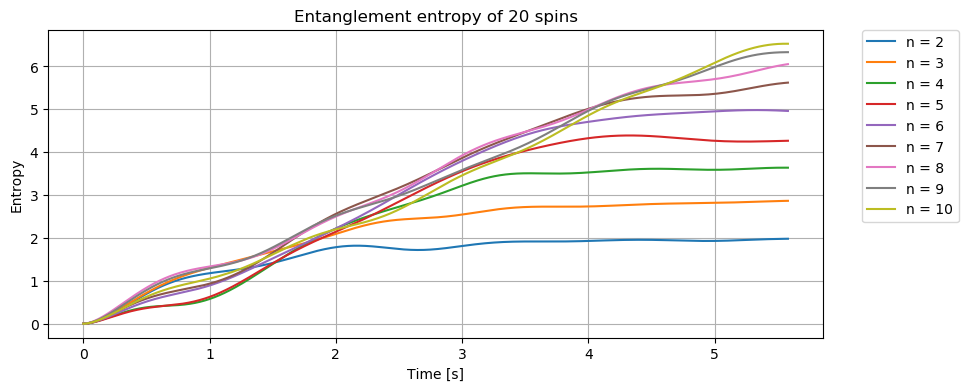

PyObject <matplotlib.legend.Legend object at 0x000000002309F358>

In [29]:
tit = "Entanglement entropy of "*string(N)*" spins"
figure("entanglement entropy", figsize =(10,4))
grid("on")
legend("on")
title(tit)
xlabel("Time [s]")
ylabel("Entropy")
for i in 1:length(store[1,:])
    lab = "n = "*string(i+1)
    plot(timearray ./ 1000, store[:,i], label=lab, linewidth = 1.5)
end
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This somehow does not work anymore.

In [75]:
savefig("plot.png", format="png")

This cell can be called in order to store the current data sets.

In [30]:
write_data(store, "entropy.txt")
write_data(timearray, "time.txt")
write_data(Psi, "psi.txt")

In [76]:
currentTime

1520.0